In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler, FunctionTransformer, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [3]:
plt.style.use("default")
sns.set_palette("Set2")

RANDOM_STATE = 42
TARGET_COL = "Status"
DROP_COL = ["id", "N_Days"]

# Этап I. Предобработка данных для ML

Загрузим данные, разделим наши признаки на числовые и категориальные, преобразуем таргет в бинарный, разделим на train и test.

In [4]:
df = pd.read_csv("../../data/train.csv").drop(columns=DROP_COL)

In [5]:
target_maps = {"C": 0, "D": 1}

binary_maps = {
    "Drug": {"Placebo": 0, "D-penicillamine": 1},
    "Sex": {"F": 0, "M": 1},
    "Ascites": {"N": 0, "Y": 1},
    "Hepatomegaly": {"N": 0, "Y": 1},
    "Spiders": {"N": 0, "Y": 1}
}

binary_features = list(binary_maps.keys())
multi_category_features = ["Edema", "Stage"]

numeric_features = ["Age", "Bilirubin", "Cholesterol", "Albumin", "Copper",
                    "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]

skewed_numeric = ["Bilirubin", "Cholesterol", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Prothrombin"]

symmetric_numeric = [col for col in numeric_features if col not in skewed_numeric]

Исходный таргет с тремя категориями преобразуем в две и будем решать задачу бинарной классификации.

Класс CL значит, что пациент выжил благодаря трансплантации печени. Но в данных нет информации о том, была ли сделана трансплантации печени или нет. Поэтому мы не можем предсказать событие CL по исходным биохимическим показателям - оно зависит не только от тяжести болезни, но и от внешних фактовров (решение врача, наличие органа для трансплантации, успешность операции). Среди представителей класса D также могли быть пациенты, которые перенесли трансплантацию печени, равно как и в классе C могут быть пациенты, которым предстоит операция, но мы об этом не знаем. Кроме того класс CL очень малочисленный: всего 3.5% против 33.7% и 62.8% классов D и C соответственно. Поэтому его разумно исключить и решать задачу в виде бинарной классификации с классами:  

- Класс 0, умеренная стадия заболевания — C (пациент жив)
- Класс 1, тяжёлая стадия заболевания — D (летальный исход)

In [6]:
df = df[df[TARGET_COL] != 'CL']
df = df.reset_index(drop=True)
df[TARGET_COL] = df[TARGET_COL].map(target_maps)

df[TARGET_COL].value_counts(normalize=True)

Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64

Разделим все данные на train и test. Подбор методов обработки признаков, настройку гиперпараметров и оценку качества будем проводить только на кросс-валидации на train. Test служит для финальной оценки качества лучшей модели.

In [7]:
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

In [8]:
print("Распределение таргета на train:")
print(y_train.value_counts(normalize=True))

print("=="*25)

print("Распределение таргета на test:")
print(y_test.value_counts(normalize=True))

Распределение таргета на train:
Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64
Распределение таргета на test:
Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64


In [9]:
class BinaryMapper(BaseEstimator, TransformerMixin):
    """
    Превращает бинарные категориальные в 0/1 по заданному словарю.
    """
    def __init__(self, mapping: dict):
        self.mapping = mapping
        self.columns_ = list(mapping.keys())

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_df = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=self.columns_)
        for col, mapping in self.mapping.items():
            X_df[col] = X_df[col].map(mapping)
        return X_df

    def get_feature_names_out(self, input_features=None):
        return self.columns_

# Этап I. Дерево решений

Для бинарных признаков и категориальных произведём кодирование данных.


In [10]:
processor_cat = ColumnTransformer(
        transformers=[
            ("binary", BinaryMapper(binary_maps), binary_features),
            ("category", OrdinalEncoder(), multi_category_features)
        ],
        remainder="passthrough",
        verbose_feature_names_out=False
    )

processor = processor_cat

X_proc = processor.fit_transform(X_train)
cols = processor.get_feature_names_out()

processed = pd.DataFrame(X_proc, columns=cols, index=X_train.index)

In [11]:
processed.describe().T

,count,mean,std,min,25%,50%,75%,max
Drug,6104.0,0.490498,0.499951,0.00,0.00,0.00,1.00,1.00
Sex,6104.0,0.070773,0.256467,0.00,0.00,0.00,0.00,1.00
Ascites,6104.0,0.048820,0.215510,0.00,0.00,0.00,0.00,1.00
Hepatomegaly,6104.0,0.501474,0.500039,0.00,0.00,1.00,1.00,1.00
Spiders,6104.0,0.241153,0.427818,0.00,0.00,0.00,0.00,1.00
Edema,6104.0,0.140891,0.459900,0.00,0.00,0.00,0.00,2.00
Stage,6104.0,2.024246,0.870287,0.00,1.00,2.00,3.00,3.00
Age,6104.0,18420.344201,3685.059634,9598.00,15601.00,18719.00,20684.00,28650.00
Bilirubin,6104.0,2.578768,3.810729,0.30,0.70,1.10,2.90,28.00
Cholesterol,6104.0,348.535059,192.842882,120.00,248.00,298.00,390.00,1775.00


Будем использовать StratifiedKFold, чтобы в каждом фолде была соблюдена пропорция классов. Установим 5 фолдов.

In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# 1. Decision Tree

In [13]:
decision_tree = Pipeline([
    ("preprocess", processor),
    ("dectree", DecisionTreeClassifier(
        random_state=RANDOM_STATE))
])

param_grid = {
    'dectree__max_depth': [3, 5, 7, None],
    'dectree__min_samples_split': [2, 5, 10, 15],
    'dectree__min_samples_leaf': [5, 10, 15, 20],
    'dectree__criterion': ['gini', 'entropy'],
    'dectree__class_weight': [None, 'balanced']
}

gs_dt= GridSearchCV(
    decision_tree,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_dt.fit(X_train, y_train)
print("Дерево решений:")
print("Лучшие параметры:", gs_dt.best_params_)
print("Лучший recall на кросс-валидации:", gs_dt.best_score_)

Дерево решений:
Лучшие параметры: {'dectree__class_weight': 'balanced', 'dectree__criterion': 'gini', 'dectree__max_depth': 7, 'dectree__min_samples_leaf': 20, 'dectree__min_samples_split': 2}
Лучший recall на кросс-валидации: 0.7861145012149399


In [14]:
y_pred_dt = cross_val_predict(
    gs_dt.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель decision tree):")
print(classification_report(y_train, y_pred_dt))

Отчёт по классам (модель decision tree):
              precision    recall  f1-score   support

           0       0.87      0.78      0.83      3972
           1       0.66      0.79      0.72      2132

    accuracy                           0.78      6104
   macro avg       0.77      0.78      0.77      6104
weighted avg       0.80      0.78      0.79      6104



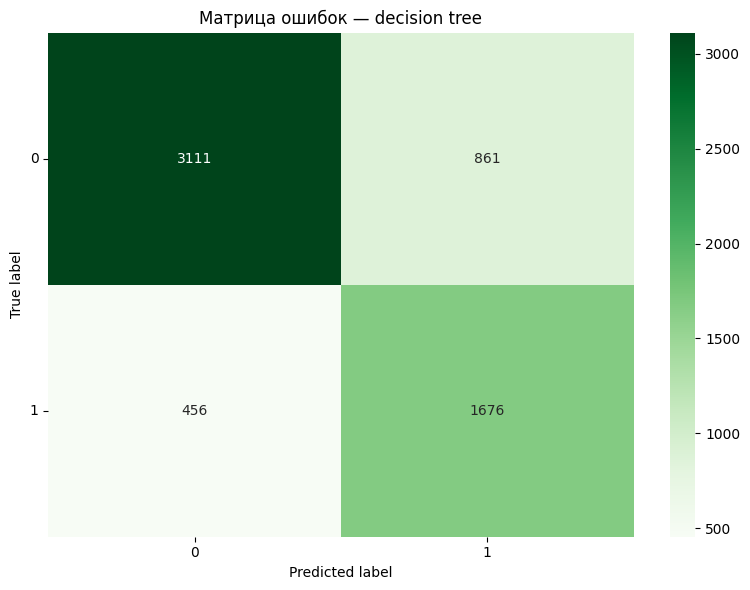

In [15]:
cm_dt = confusion_matrix(y_train, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Greens")
plt.title("Матрица ошибок — decision tree")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

# 2. Decision Tree + Downsampling класса большинства

Используем простой способ, чтобы выровнять пропорцию классов: просто удалим некоторые объекты класса большинства.

In [16]:
pipeline_us = ImbPipeline(steps=[
    ("preprocess", processor),
    ("undersample", RandomUnderSampler(random_state=RANDOM_STATE)),
    ("dectree", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = {
    'dectree__max_depth': [3, 5, 7, None],
    'dectree__min_samples_split': [2, 5, 10, 15],
    'dectree__min_samples_leaf': [5, 10, 15, 20],
    'dectree__criterion': ['gini', 'entropy'],
    'dectree__class_weight': [None, 'balanced']
}

gs_us_dt = GridSearchCV(
    pipeline_us,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_us_dt.fit(X_train, y_train)
print("RandomDownSampler + дерево решений")
print("Лучшие параметры:", gs_us_dt.best_params_)
print("Лучший recall на кросс-валидации:", gs_us_dt.best_score_)

RandomDownSampler + дерево решений
Лучшие параметры: {'dectree__class_weight': None, 'dectree__criterion': 'entropy', 'dectree__max_depth': 3, 'dectree__min_samples_leaf': 5, 'dectree__min_samples_split': 2}
Лучший recall на кросс-валидации: 0.7907983419643544


In [17]:
y_pred_us_dt = cross_val_predict(
    gs_us_dt.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель с RandomUnderSampler):")
print(classification_report(y_train, y_pred_us_dt))

Отчёт по классам (модель с RandomUnderSampler):
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      3972
           1       0.64      0.79      0.71      2132

    accuracy                           0.77      6104
   macro avg       0.76      0.78      0.76      6104
weighted avg       0.79      0.77      0.78      6104



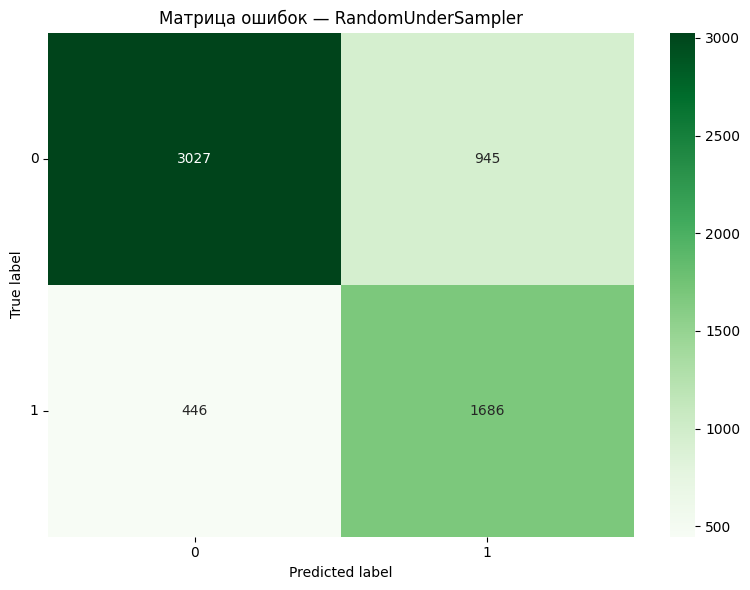

In [18]:
cm = confusion_matrix(y_train, y_pred_us_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Матрица ошибок — RandomUnderSampler")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

В данном случае recall остаётся на том же уровне 0.79, но появились потери в precision 0.66 -> 0.64.

## 3. Decision Tree + Upsampling класса меньшинства

In [19]:
pipeline_os = ImbPipeline(steps=[
    ("preprocess", processor),
    ("oversample", RandomOverSampler(random_state=RANDOM_STATE)),
    ("dectree", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = {
    'dectree__max_depth': [3, 5, 7, None],
    'dectree__min_samples_split': [2, 5, 10, 15],
    'dectree__min_samples_leaf': [5, 10, 15, 20],
    'dectree__criterion': ['gini', 'entropy']
}

gs_os_dt = GridSearchCV(
    pipeline_os,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_os_dt.fit(X_train, y_train)
print("RandomOverSampler + дерево решений")
print("Лучшие параметры:", gs_os_dt.best_params_)
print("Лучший recall на кросс-валидации:", gs_os_dt.best_score_)

RandomOverSampler + дерево решений
Лучшие параметры: {'dectree__criterion': 'gini', 'dectree__max_depth': 7, 'dectree__min_samples_leaf': 10, 'dectree__min_samples_split': 2}
Лучший recall на кросс-валидации: 0.7795571241657596


In [20]:
y_pred_os_dt = cross_val_predict(
    gs_os_dt.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель с RandomOverSampler):")
print(classification_report(y_train, y_pred_os_dt))

Отчёт по классам (модель с RandomOverSampler):
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      3972
           1       0.70      0.78      0.74      2132

    accuracy                           0.80      6104
   macro avg       0.79      0.80      0.79      6104
weighted avg       0.81      0.80      0.81      6104



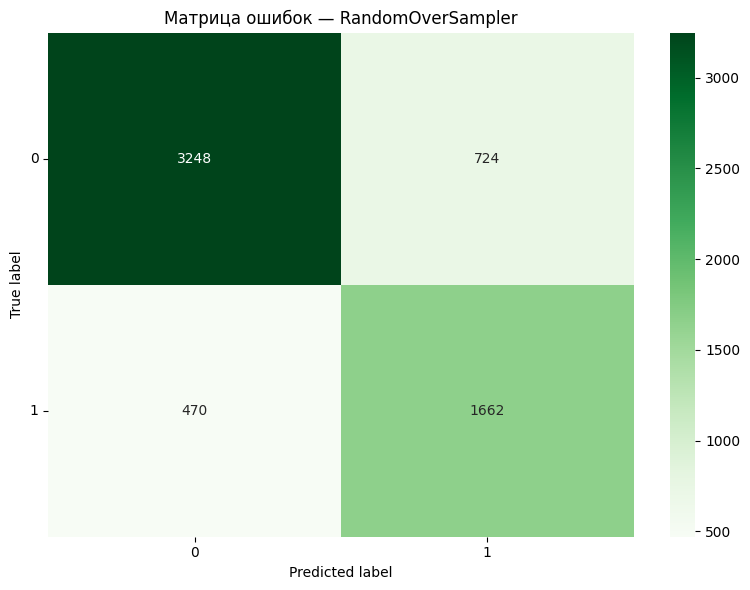

In [21]:
cm = confusion_matrix(y_train, y_pred_os_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Матрица ошибок — RandomOverSampler")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

Здесь чуть теряем в recall 0.79 -> 0.78, зато возрастаем в precision 0.64 -> 0.70

## 4. Decision Tree + SMOTE

In [22]:
pipeline_smote = ImbPipeline(steps=[
    ("preprocess", processor),
    ("smote", SMOTE(random_state=RANDOM_STATE, k_neighbors=5),
    ),
    ("dectree", DecisionTreeClassifier(random_state=RANDOM_STATE))
])


param_grid = {
    'dectree__max_depth': [3, 5, 7, None],
    'dectree__min_samples_split': [2, 5, 10, 15],
    'dectree__min_samples_leaf': [5, 10, 15, 20],
    'dectree__criterion': ['gini', 'entropy']
}

gs_smote_dt = GridSearchCV(
    pipeline_smote,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_smote_dt.fit(X_train, y_train)
print("SMOTE + дерево решений")
print("Лучшие параметры:", gs_smote_dt.best_params_)
print("Лучший recall на кросс-валидации:", gs_smote_dt.best_score_)

SMOTE + дерево решений
Лучшие параметры: {'dectree__criterion': 'gini', 'dectree__max_depth': 7, 'dectree__min_samples_leaf': 5, 'dectree__min_samples_split': 15}
Лучший recall на кросс-валидации: 0.7392134226121758


In [23]:
y_pred_smote_dt = cross_val_predict(
    gs_smote_dt.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель SMOTE):")
print(classification_report(y_train, y_pred_smote_dt))

Отчёт по классам (модель SMOTE):
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      3972
           1       0.72      0.74      0.73      2132

    accuracy                           0.81      6104
   macro avg       0.79      0.79      0.79      6104
weighted avg       0.81      0.81      0.81      6104



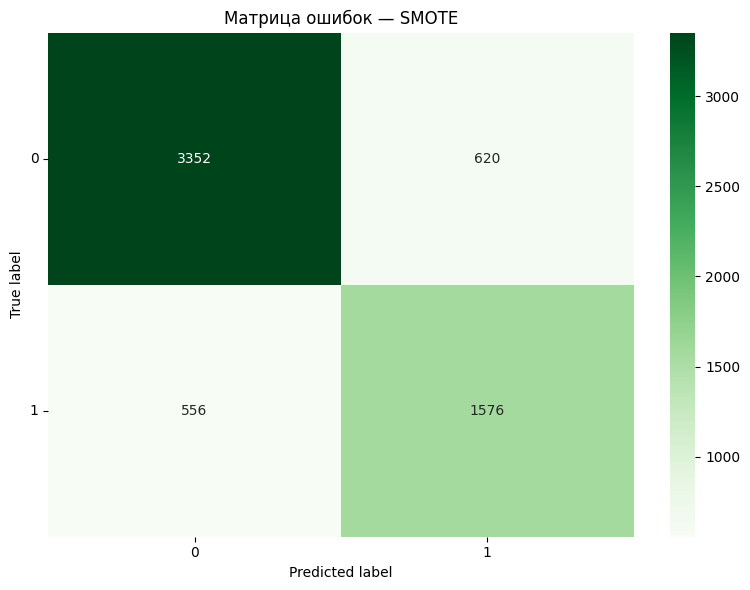

In [24]:
cm = confusion_matrix(y_train, y_pred_smote_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Матрица ошибок — SMOTE")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

В данной модели метрика recall равна 0.74, а precision - 0.72. Precision имеет лучший результат из вышеперечисленных моделей, но в данном случае снизился recall, который имеет здесь **важное** значение, так как со снижением recall мы пропускаем действительно больного пациента. 

Среди всех проделанных моделей оптимальной по балансу метрик recall и precision является модель *Decision Tree + Upsampling класса меньшинства* с метриками:

- recall - 0.78
- precision - 0.70

Визуализируем дерево итоговой лучшей модели:

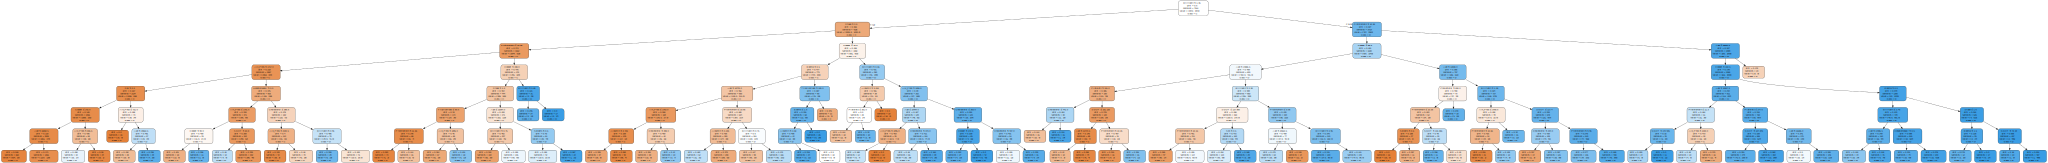

In [25]:
best_dt_pipeline = gs_os_dt.best_estimator_
best_dt_tree = best_dt_pipeline.named_steps['dectree']

dot_data = export_graphviz(best_dt_tree,
                           out_file=None,
                           feature_names=pipeline_os.named_steps["preprocess"].get_feature_names_out(),
                           class_names=list(target_maps.keys()),
                           filled=True,
                           rounded=True,
                           special_characters=True)

graph = graphviz.Source(dot_data)
graph

# Этап II. Случайный лес

In [26]:
#В результате обработки данных
processor = processor_cat

X_proc = processor.fit_transform(X_train)
cols = processor.get_feature_names_out()

processed = pd.DataFrame(X_proc, columns=cols, index=X_train.index)

## 1. Random Forest

In [27]:
random_forest = Pipeline([
    ("preprocess", processor),
    ("ranforest", RandomForestClassifier(
        random_state=RANDOM_STATE, n_jobs=-1))
])

param_grid = {
    'ranforest__n_estimators': [50, 100],
    'ranforest__max_depth': [None, 10, 20],
    'ranforest__min_samples_split': [2, 5],
    'ranforest__min_samples_leaf': [1, 2],
    'ranforest__max_features': ['sqrt', 'log2'],
    'ranforest__bootstrap': [True, False],
    'ranforest__class_weight': ['balanced'],
    'ranforest__criterion': ['gini', 'entropy']

}

gs_rf= GridSearchCV(
    random_forest,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_rf.fit(X_train, y_train)
print("Случайный лес:")
print("Лучшие параметры:", gs_rf.best_params_)
print("Лучший recall на кросс-валидации:", gs_rf.best_score_)

Случайный лес:
Лучшие параметры: {'ranforest__bootstrap': False, 'ranforest__class_weight': 'balanced', 'ranforest__criterion': 'entropy', 'ranforest__max_depth': 10, 'ranforest__max_features': 'sqrt', 'ranforest__min_samples_leaf': 2, 'ranforest__min_samples_split': 5, 'ranforest__n_estimators': 50}
Лучший recall на кросс-валидации: 0.7725247660828358


In [28]:
y_pred_rf = cross_val_predict(
    gs_rf.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель Случайный лес):")
print(classification_report(y_train, y_pred_rf))

Отчёт по классам (модель Случайный лес):
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      3972
           1       0.77      0.77      0.77      2132

    accuracy                           0.84      6104
   macro avg       0.82      0.82      0.82      6104
weighted avg       0.84      0.84      0.84      6104



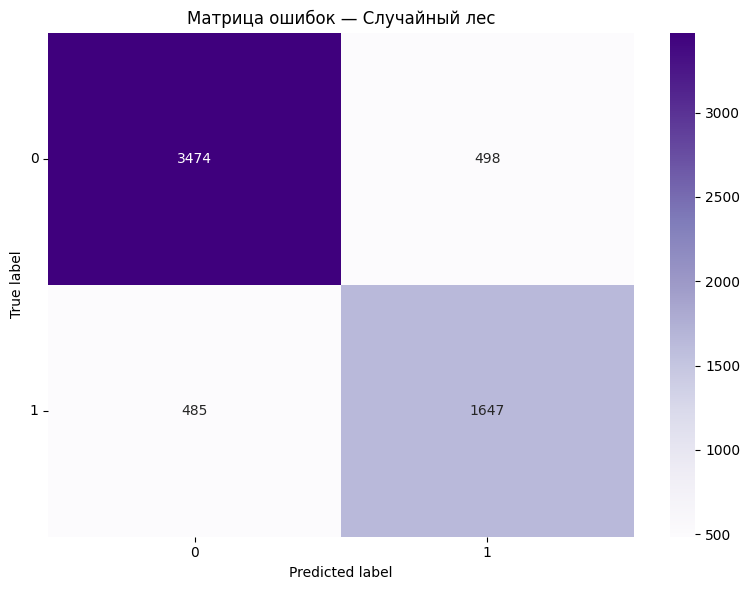

In [29]:
cm_rf = confusion_matrix(y_train, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Purples")
plt.title("Матрица ошибок — Случайный лес")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

Метрики сравнялись, стали лучше предсказывать выживаемость, возможно это связано с дисбалансом классов, где смертность является миноритарным классом. Recall стал чуть хуже, чем в деревьях решений. Попробуем применить методы устранения дисбаланса классов.

# 2. Random Forest + Downsampling класса большинства

In [30]:
pipeline_us = ImbPipeline(steps=[
    ("preprocess", processor),
    ("undersample", RandomUnderSampler(random_state=RANDOM_STATE)),
    ("ranforest", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

param_grid = {
    'ranforest__n_estimators': [50, 100],
    'ranforest__max_depth': [None, 10, 20],
    'ranforest__min_samples_split': [2, 5],
    'ranforest__min_samples_leaf': [1, 2],
    'ranforest__max_features': ['sqrt', 'log2'],
    'ranforest__bootstrap': [True, False],
    'ranforest__class_weight': ['balanced'],
    'ranforest__criterion': ['gini', 'entropy']

}

gs_us_rf = GridSearchCV(
    pipeline_us,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_us_rf.fit(X_train, y_train)
print("RandomDownSampler + случайный лес")
print("Лучшие параметры:", gs_us_rf.best_params_)
print("Лучший recall на кросс-валидации:", gs_us_rf.best_score_)

RandomDownSampler + случайный лес
Лучшие параметры: {'ranforest__bootstrap': True, 'ranforest__class_weight': 'balanced', 'ranforest__criterion': 'entropy', 'ranforest__max_depth': None, 'ranforest__max_features': 'sqrt', 'ranforest__min_samples_leaf': 1, 'ranforest__min_samples_split': 5, 'ranforest__n_estimators': 100}
Лучший recall на кросс-валидации: 0.8241096854350145


In [31]:
y_pred_us_rf = cross_val_predict(
    gs_us_rf.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель с RandomUnderSampler):")
print(classification_report(y_train, y_pred_us_rf))

Отчёт по классам (модель с RandomUnderSampler):
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      3972
           1       0.73      0.82      0.77      2132

    accuracy                           0.83      6104
   macro avg       0.81      0.83      0.82      6104
weighted avg       0.84      0.83      0.83      6104



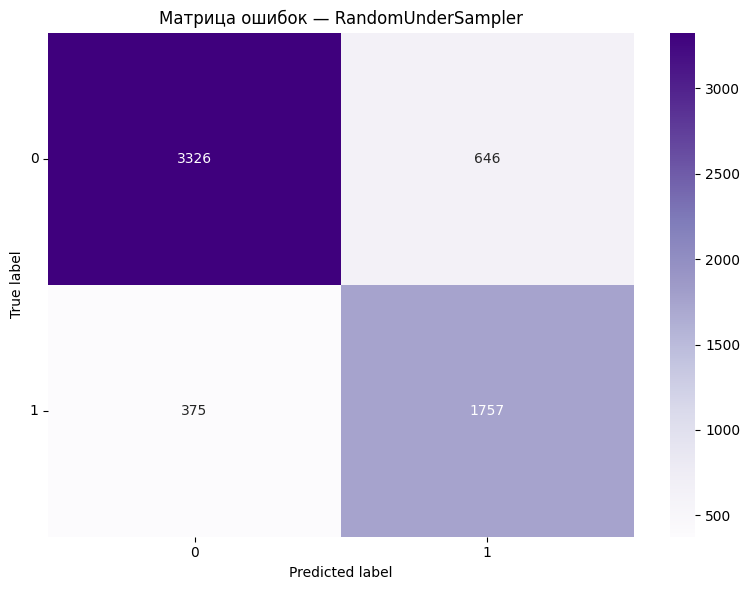

In [32]:
cm = confusion_matrix(y_train, y_pred_us_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("Матрица ошибок — RandomUnderSampler")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

Результат сильно улучшился. Recall возрос до 0.82, а precision остался на уровне 0.73. 

## 3. Random Forest + Upsampling класса меньшинства

In [33]:
pipeline_us = ImbPipeline(steps=[
    ("preprocess", processor),
    ("oversample", RandomOverSampler(random_state=RANDOM_STATE)),
    ("ranforest", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

param_grid = {
    'ranforest__n_estimators': [50, 100],
    'ranforest__max_depth': [None, 10, 20],
    'ranforest__min_samples_split': [2, 5],
    'ranforest__min_samples_leaf': [1, 2],
    'ranforest__max_features': ['sqrt', 'log2'],
    'ranforest__bootstrap': [True, False],
    'ranforest__class_weight': ['balanced'],
    'ranforest__criterion': ['gini', 'entropy']

}

gs_os_rf = GridSearchCV(
    pipeline_us,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_os_rf.fit(X_train, y_train)
print("RandomOverSampler + случайный лес")
print("Лучшие параметры:", gs_os_rf.best_params_)
print("Лучший recall на кросс-валидации:", gs_os_rf.best_score_)

RandomOverSampler + случайный лес
Лучшие параметры: {'ranforest__bootstrap': True, 'ranforest__class_weight': 'balanced', 'ranforest__criterion': 'entropy', 'ranforest__max_depth': 10, 'ranforest__max_features': 'sqrt', 'ranforest__min_samples_leaf': 2, 'ranforest__min_samples_split': 5, 'ranforest__n_estimators': 100}
Лучший recall на кросс-валидации: 0.7758100515662278


In [34]:
y_pred_os_rf = cross_val_predict(
    gs_os_rf.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель с RandomOverSampler):")
print(classification_report(y_train, y_pred_os_rf))

Отчёт по классам (модель с RandomOverSampler):
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      3972
           1       0.77      0.78      0.77      2132

    accuracy                           0.84      6104
   macro avg       0.82      0.82      0.82      6104
weighted avg       0.84      0.84      0.84      6104



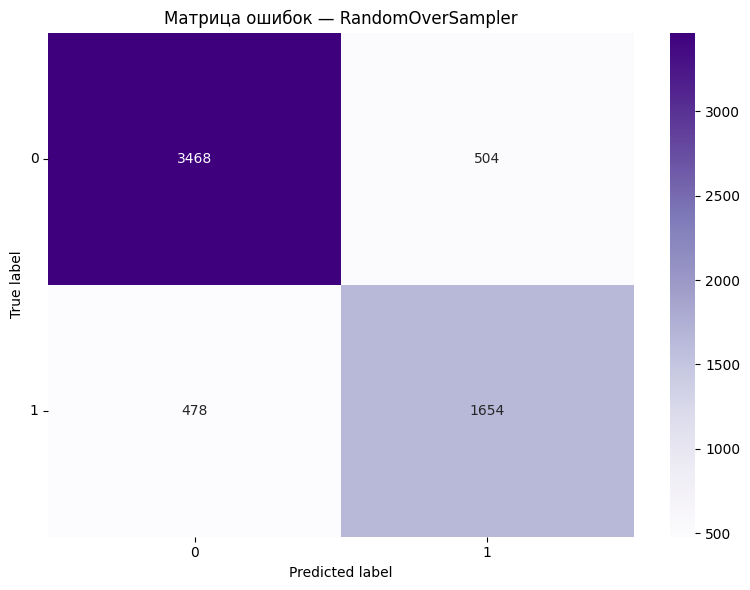

In [35]:
cm = confusion_matrix(y_train, y_pred_os_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("Матрица ошибок — RandomOverSampler")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

Получилось хуже, так как снизился recall до 0.78

# 4. Random Forest + SMOT

In [36]:
pipeline_smote = ImbPipeline(steps=[
    ("preprocess", processor),
    ("smote", SMOTE(random_state=RANDOM_STATE, k_neighbors=5),
    ),
    ("ranforest", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])


param_grid = {
    'ranforest__n_estimators': [50, 100],
    'ranforest__max_depth': [None, 10, 20],
    'ranforest__min_samples_split': [2, 5],
    'ranforest__min_samples_leaf': [1, 2],
    'ranforest__max_features': ['sqrt', 'log2'],
    'ranforest__bootstrap': [True, False],
    'ranforest__class_weight': ['balanced'],
    'ranforest__criterion': ['gini', 'entropy']

}

gs_smote_rf = GridSearchCV(
    pipeline_smote,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_smote_rf.fit(X_train, y_train)
print("SMOTE + случайный лес")
print("Лучшие параметры:", gs_smote_rf.best_params_)
print("Лучший recall на кросс-валидации:", gs_smote_rf.best_score_)

SMOTE + случайный лес
Лучшие параметры: {'ranforest__bootstrap': True, 'ranforest__class_weight': 'balanced', 'ranforest__criterion': 'gini', 'ranforest__max_depth': None, 'ranforest__max_features': 'sqrt', 'ranforest__min_samples_leaf': 1, 'ranforest__min_samples_split': 5, 'ranforest__n_estimators': 100}
Лучший recall на кросс-валидации: 0.7598597046761443


In [37]:
y_pred_smote_rf = cross_val_predict(
    gs_smote_rf.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель SMOTE):")
print(classification_report(y_train, y_pred_smote_rf))

Отчёт по классам (модель SMOTE):
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      3972
           1       0.77      0.76      0.77      2132

    accuracy                           0.84      6104
   macro avg       0.82      0.82      0.82      6104
weighted avg       0.84      0.84      0.84      6104



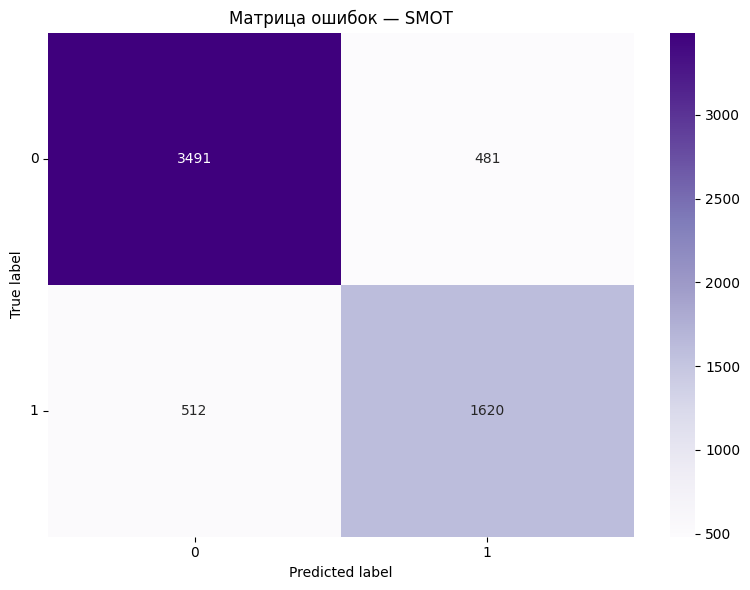

In [38]:
cm = confusion_matrix(y_train, y_pred_smote_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("Матрица ошибок — SMOT")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

### Промежуточный вывод: 

В контексте поставленной задачи лучше, чем все остальные, показала себя модель *Random Forest + Downsampling класса большинства* с recall = 0.82 и precision = 0.73.
Есть модели с лучшим precision, но так как важнее не пропускать пациентов, которые действительно больны (FN), то опираемся на метрику recall.

# Изменение порога

Попробуем изменить порог для выбранной модели *Random Forest + Downsampling класса большинства*.

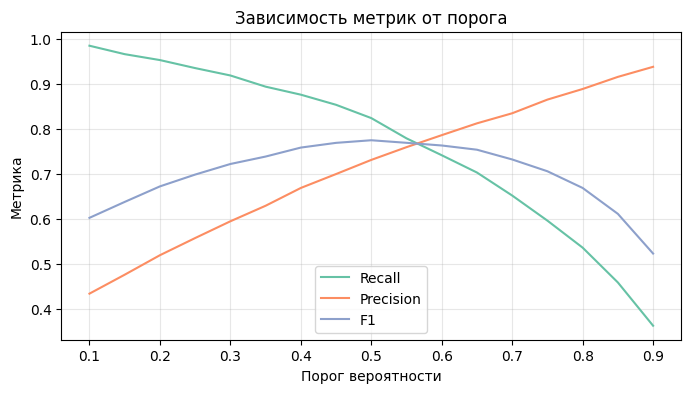

In [39]:
y_proba_us_rf = cross_val_predict(
    gs_us_rf.best_estimator_,
    X_train, y_train,
    cv=skf,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

thresholds = np.arange(0.1, 0.91, 0.05)
recalls, precisions, f1s = [], [], []

for thr in thresholds:
    y_thr = (y_proba_us_rf >= thr).astype(int)
    recalls.append(recall_score(y_train, y_thr))
    precisions.append(precision_score(y_train, y_thr))
    f1s.append(f1_score(y_train, y_thr))

plt.figure(figsize=(8, 4))
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, f1s, label="F1")
plt.xlabel("Порог вероятности")
plt.ylabel("Метрика")
plt.legend()
plt.grid(alpha=0.3)
plt.title("Зависимость метрик от порога")
plt.show()

Выберем порог 0.4 и попытаемся улучшить recall.

In [40]:
THRESHOLD = 0.4

y_pred_us_rf_thr = (y_proba_us_rf >= THRESHOLD).astype(int)

print(f"Отчёт по классам (модель Random Forest + Downsampling класса большинства и порогом {THRESHOLD}):")
print(classification_report(y_train, y_pred_us_rf_thr))

Отчёт по классам (модель Random Forest + Downsampling класса большинства и порогом 0.4):
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      3972
           1       0.67      0.88      0.76      2132

    accuracy                           0.81      6104
   macro avg       0.79      0.82      0.80      6104
weighted avg       0.83      0.81      0.81      6104



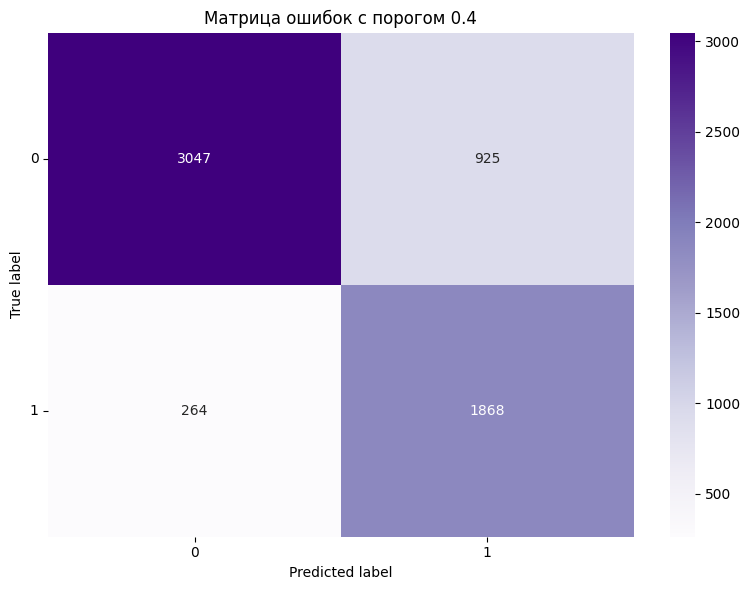

In [41]:
cm = confusion_matrix(y_train, y_pred_us_rf_thr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title(f"Матрица ошибок c порогом {THRESHOLD}")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

Значительно улучшилось число определения тяжёлых пациентов (recall 0.82 -> 0.88), но потребуется больше перепроверять пациентов, которых ложно определили как тяжело больных (precision 0.73 -> 0.67).

# Этап III. Проверка на тесте

In [42]:
best_params = gs_us_rf.best_params_
print(f"Лучшие параметры: {best_params}")

Лучшие параметры: {'ranforest__bootstrap': True, 'ranforest__class_weight': 'balanced', 'ranforest__criterion': 'entropy', 'ranforest__max_depth': None, 'ranforest__max_features': 'sqrt', 'ranforest__min_samples_leaf': 1, 'ranforest__min_samples_split': 5, 'ranforest__n_estimators': 100}


In [48]:
final_pipeline = ImbPipeline([
    ("preprocess", processor),
    ("undersample", RandomUnderSampler(random_state=RANDOM_STATE)),
    ("ranforest", RandomForestClassifier(
        random_state=RANDOM_STATE,
        bootstrap=best_params["ranforest__bootstrap"],
        criterion=best_params["ranforest__criterion"],
        max_depth=best_params["ranforest__max_depth"],
        max_features=best_params["ranforest__max_features"],
        min_samples_leaf=best_params["ranforest__min_samples_leaf"],
        min_samples_split=best_params["ranforest__min_samples_split"],
        n_estimators=best_params["ranforest__n_estimators"],
        class_weight=best_params["ranforest__class_weight"],
        n_jobs=-1,
    ))
])

# обучение на всём train
final_pipeline.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('undersample', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('binary', ...), ('category', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


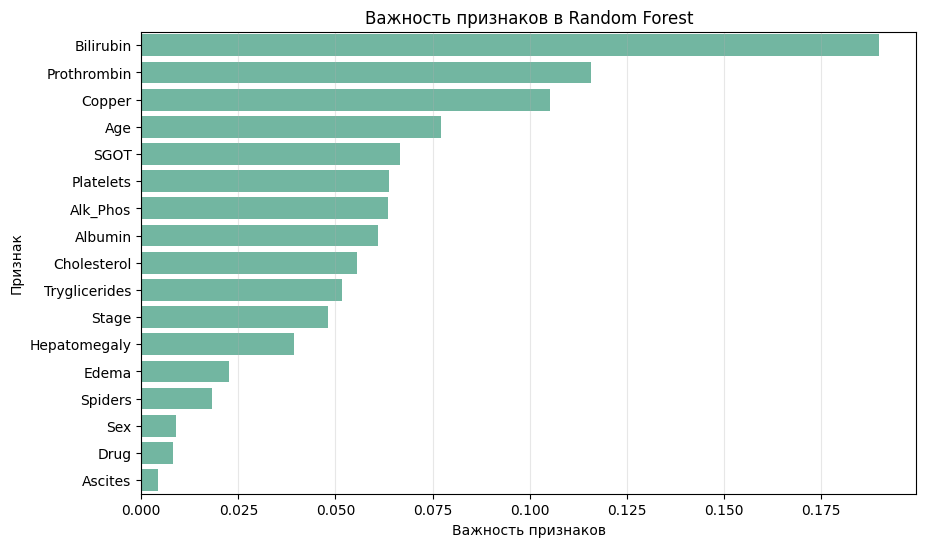

In [44]:
preprocess_step = final_pipeline.named_steps["preprocess"]
feature_names = preprocess_step.get_feature_names_out()

ranforest_step = final_pipeline.named_steps["ranforest"]
coefs = ranforest_step.feature_importances_

feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': coefs,
}).sort_values('importance', ascending=False)

# Построение горизонтального bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, y='feature', x='importance')
plt.xlabel('Важность признаков')
plt.ylabel('Признак')

plt.title('Важность признаков в Random Forest')
plt.grid(axis='x', alpha=0.3)
plt.show()

In [45]:
y_predict_test = final_pipeline.predict(X_test)

In [46]:
print(f"Отчёт по классам на тесте:")
print(classification_report(y_test, y_predict_test))

Отчёт по классам на тесте:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       993
           1       0.70      0.80      0.75       533

    accuracy                           0.81      1526
   macro avg       0.79      0.81      0.80      1526
weighted avg       0.82      0.81      0.81      1526



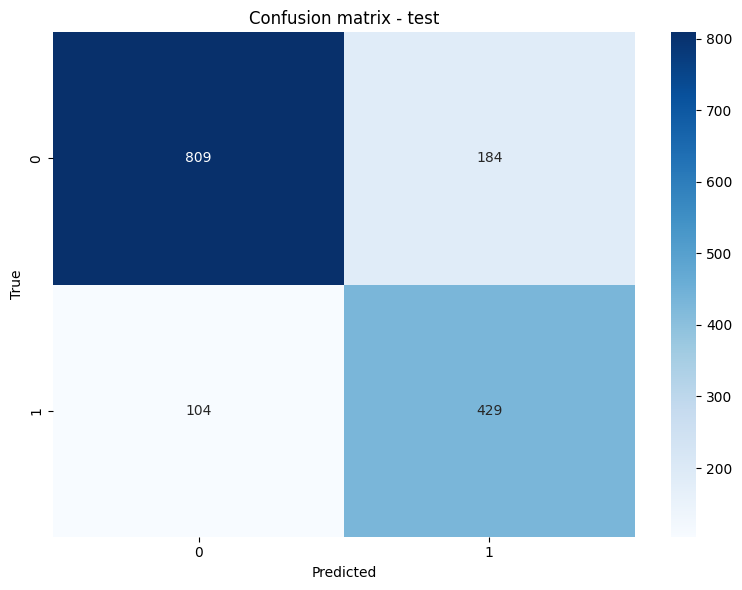

In [47]:
cm_test = confusion_matrix(y_test, y_predict_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion matrix - test")
plt.tight_layout()
plt.show()

В данном случае значения метрик не сильно отличаются от метрик на кросс-валидации. Порог не менялся, оставили по умолчанию 0.5.

Это позволяет найти баланс между большим процентом определения тяжело больных пациентов и меньшим процентом потерь здоровых пациентов среди тех, кого модель назвала тяжёлыми.

# Выводы:

**Предобработка:**

Числовые признаки остались неизменными. Бинарные были закодированы в 0/1, многокатегориальные — в коды (OrdinalEncoder).

**Моделирование:**

Проведена оценка разных моделей Деревьей решений и Случайного леса, а так же методов для борьбы дисбаланса классов. Лучший результат по метрикам показала модель *Random Forest + Downsampling класса большинства*.

**Результаты:**

На тесте модель показывает recall класса 1 = 0.80 и приемлемый precision = 0.70, что делает её оптимальной при определении действительно тяжёлых пациентов и ошибок на пациентов с положительным прогнозом. 

Важнейшие признаки: Bilirubin, Cooper, Prothrombin, Age, SGOT.